**Install required packages**

In [ ]:
!pip install transformers
!pip install datasets
!pip install path_explain

**Imports**

In [ ]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, DistilBertConfig, DistilBertForSequenceClassification
from path_explain import PathExplainerTF, text_plot, PathExplainerTorch
import tensorflow as tf
import random


**Import data**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/test (1).csv')
text = list(data['text'].values)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train (1).csv')
train_text = list(train['text'].values)

**Initialize model and tokenizer**

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=2)
model = TFDistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/tfdistilbert_dizertatie3', config=config)

def embedding_model(batch_ids):
    batch_embedding = model.distilbert.embeddings(batch_ids)
    return batch_embedding

def prediction_model(batch_embedding):
    # Note: this isn't exactly the right way to use the attention mask.
    # It should actually indicate which words are real words. This
    # makes the coding easier however, and the output is fairly similar,
    # so it suffices for this tutorial.
    attention_mask = tf.ones(batch_embedding.shape[:2])
    attention_mask = tf.cast(attention_mask, dtype=tf.float32)
    head_mask = [None] * model.distilbert.num_hidden_layers

    transformer_output = model.distilbert.transformer(batch_embedding, attention_mask, head_mask, training = False, output_attentions = True, output_hidden_states = True, return_dict = True)[0]
    pooled_output = transformer_output[:, 0]
    pooled_output = model.pre_classifier(pooled_output)
    logits = model.classifier(pooled_output)
    return logits

Some layers from the model checkpoint at /content/drive/MyDrive/tfdistilbert_dizertatie3 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_79']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/tfdistilbert_dizertatie3 and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Prepare embeddings**

In [ ]:
def get_embeddings(sentence):
  tokenized_text = tokenizer.prepare_seq2seq_batch([sentence], return_tensors='pt', padding = 'max_length', truncation = True, max_length = 128)
  batch_embedding = embedding_model(tokenized_text['input_ids'])
  s = batch_embedding.shape[1]

  baseline_ids = np.zeros((1, s), dtype=np.int64)
  baseline_embedding = embedding_model(baseline_ids)

  return baseline_embedding, batch_embedding, tokenized_text

# baseline_embedding, batch_embedding, tokenized_text = get_embeddings(text[1174])

In [ ]:
def get_embeddings(tokenized_text):
  # tokenized_text = tokenizer.prepare_seq2seq_batch([sentence], return_tensors='pt', padding = 'max_length', truncation = True, max_length = 128)
  batch_embedding = embedding_model(tokenized_text['input_ids'])
  

  return baseline_embedding, batch_embedding

# baseline_embedding, batch_embedding, tokenized_text = get_embeddings(text[1174])

In [ ]:
tokenized_train = tokenizer.prepare_seq2seq_batch(random.sample(train_text, 50), return_tensors = 'pt', max_length = 128, padding = True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


In [ ]:
batch_embeddings = embedding_model(tokenized_train['input_ids'])

In [ ]:
baseline_embedding, batch_embedding, tokenized_text = get_embeddings(text[1174])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


**Initialize and run explainer**

In [ ]:
explainer = PathExplainerTF(prediction_model)

In [ ]:
def probabs(sentences):
  tokenized_text = tokenizer.prepare_seq2seq_batch(sentences, return_tensors='pt')
  batch_embedding = embedding_model(tokenized_text['input_ids'])

  return prediction_model(batch_embedding)

In [ ]:
def faithfulness_metric(predict_proba, cls_explainer, text, tokenizer):
    # calculate word attributions
    pred_class = np.argmax(predict_proba(text))
    # tokens = np.array(tokenizer.prepare_seq2seq_batch(text, return_tensors='pt')['input_ids'])
    # x = tokens[0][1:-1]
    baseline_embedding, batch_embedding, tokenized_text = get_embeddings(text)

    attributions = cls_explainer.attributions(inputs=batch_embedding,
                                      baseline=batch_embeddings,
                                      batch_size=4,
                                      num_samples=128,
                                      use_expectation=True,
                                      output_indices=1)

    attributions = np.mean(attributions, axis = 2)
    coefs = attributions[:tokenized_text['input_ids'].numpy()[0].shape[0]]
    if len(coefs) > 512:
      coefs = coefs[:512]
    
    x = tokenized_text['input_ids'].numpy()[0]
    coefs = np.array(coefs)
    base = np.zeros(x.shape[0])


    #find indexs of coefficients in decreasing order of value
    ar = np.argsort(-coefs)  #argsort returns indexes of values sorted in increasing order; so do it for negated array
    pred_probs = np.zeros(x.shape[0])
    print(coefs.shape)
    print(ar.shape)
    print(x.shape)

    for ind in np.nditer(ar):
        x_copy = x.copy()
        x_copy[ind] = base[ind]
        decoded_copy = tokenizer.decode(x_copy)
        x_copy_pr = predict_proba(decoded_copy)[0]
        pred_probs[ind] = x_copy_pr[pred_class]

    return -np.corrcoef(coefs, pred_probs)[0,1]

In [ ]:
tokenized_text['input_ids'].numpy()[0].shape[0]

128

In [ ]:
baseline_embedding, batch_embedding, tokenized_text = get_embeddings(text[1174])

attributions = explainer.attributions(inputs=batch_embedding,
                                  baseline=batch_embeddings,
                                  batch_size=1,
                                  num_samples=128,
                                  use_expectation=True,
                                  output_indices=1)

attributions = np.mean(attributions, axis = 2)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


In [ ]:
tokenized_text['input_ids'].shape

torch.Size([1, 128])

In [ ]:
text_plot(,
          attributions[0],
          include_legend=True)

In [ ]:
attributions

In [ ]:
attributions[attributions != 0].shape

(127,)

In [ ]:
tokens = np.array(tokenizer.prepare_seq2seq_batch(text[1174], return_tensors='pt')['input_ids'])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


In [ ]:
batch_embedding

In [ ]:
tokens

In [ ]:
faithfulness_metric(probabs, explainer, text[10], tokenizer)

In [ ]:
metrics = pd.read_csv('drive/MyDrive/metrics_sample.csv')

metrics_text = metrics['text'].values

In [ ]:
!pip install tqdm

from tqdm import tqdm

In [ ]:
faithfulness_array = []
for t in tqdm(metrics_text):
  faithfulness_array.append(faithfulness_metric(probabs, explainer, t, tokenizer))

l = np.array(faithfulness_array)

In [ ]:
l.mean()

0.22135034735808465

In [ ]:
def monotonicity_metric(predict_proba, cls_explainer, text, tokenizer):
    # calculate word attributions
    pred_class = np.argmax(predict_proba(text))
    # tokens = np.array(tokenizer.prepare_seq2seq_batch(text, return_tensors='pt')['input_ids'])
    # x = tokens[0][1:-1]
    baseline_embedding, batch_embedding, tokenized_text = get_embeddings(text)

    attributions = explainer.attributions(inputs=batch_embedding,
                                      baseline=batch_embeddings,
                                      batch_size=4,
                                      num_samples=128,
                                      use_expectation=True,
                                      output_indices=1)

    attributions = np.mean(attributions, axis = 2)
    coefs = attributions[:tokenized_text['input_ids'].numpy()[0].shape[0]]
    if len(coefs) > 512:
      coefs = coefs[:512]
    
    x = tokenized_text['input_ids'].numpy()[0]
    coefs = np.array(coefs)
    base = np.zeros(x.shape[0])

    x_copy = base.copy()

    #find indexs of coefficients in increasing order of value
    ar = np.argsort(coefs)
    pred_probs = np.zeros(x.shape[0])
    for ind in np.nditer(ar):
        x_copy[ind] = x[ind]
        decoded_copy = tokenizer.decode(x_copy.astype(int))
        x_copy_pr = predict_proba(decoded_copy).numpy()[0]
        pred_probs[ind] = x_copy_pr[pred_class]
    
    return np.all(np.diff(pred_probs[ar]) >= 0)

In [ ]:
monotonicity_metric(probabs, explainer, text[1174], tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


(128,)
[ 3.4688473 -3.5866778]
[ 3.4753413 -3.5941744]
[ 3.4838092 -3.6002474]
[ 3.480354  -3.5964882]
[ 3.4825766 -3.5980349]
[ 3.4825766 -3.5980349]
[ 3.4839077 -3.5992868]
[ 3.4856918 -3.600516 ]
[ 3.4861557 -3.6005492]
[ 3.4861557 -3.6005492]
[ 3.4861557 -3.6005492]
[ 3.4860423 -3.600408 ]
[ 3.4860423 -3.600408 ]
[ 3.4860423 -3.600408 ]
[ 3.4867198 -3.6006305]
[ 3.486649 -3.60061 ]
[ 3.486649 -3.60061 ]
[ 3.487525  -3.6007576]
[ 3.487525  -3.6007576]
[ 3.487525  -3.6007576]
[ 3.487525  -3.6007576]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.487376  -3.6006932]
[ 3.486465  -3.5839353]
[ 3.486465  -3.5839353]
[ 3.486465  -3.5839353]
[ 3.486465  -

False

In [ ]:
tokens = np.array(tokenizer.prepare_seq2seq_batch(text[1174], return_tensors='pt')['input_ids'])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


In [ ]:
import pickle

with open('faithfulness_expected.pkl', 'wb') as f:
  pickle.dump(l, f)

In [ ]:
tokens[0][1:-1]

array([ 2115,  7604,  2024, 18015,  2758,  1037, 18856,  9581,  3406,
        9966,  9575,  2124,  2011,  1996,  4045,  2451,  2004,  1996,
       13638,  3466,  2029,  2003,  1056, 26016, 10362,  2003,  4011,
        2000,  2022, 10539])

In [ ]:
attributions = explainer.attributions(inputs=batch_embedding,
                                      baseline=baseline_embedding,
                                      batch_size=1,
                                      num_samples=128,
                                      use_expectation=True,
                                      output_indices=1)

attributions = np.mean(attributions, axis = 2)

In [ ]:
len(text[1174].split())

25

In [ ]:
attributions

In [ ]:
attributions[attributions != 0]

0.0002987554826356191

In [ ]:
attributions

**Display attributions**

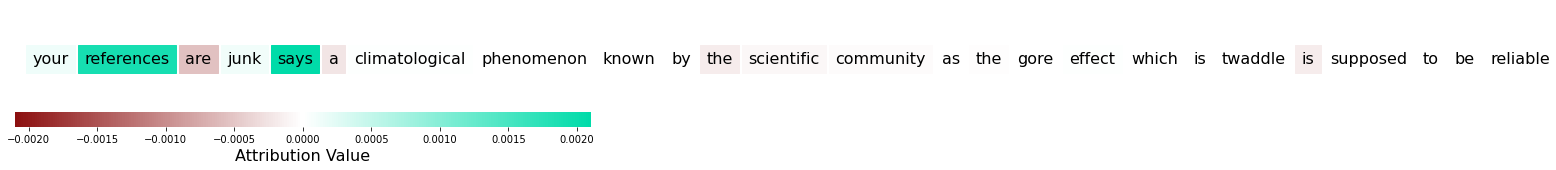

In [ ]:
decoded_sentence = tokenizer.batch_decode(tokenized_text['input_ids'])
sentence = decoded_sentence[0].replace("[PAD]", "").split()
sentence = sentence[1:-1]

text_plot(sentence,
          attributions[0][:len(sentence)],
          include_legend=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


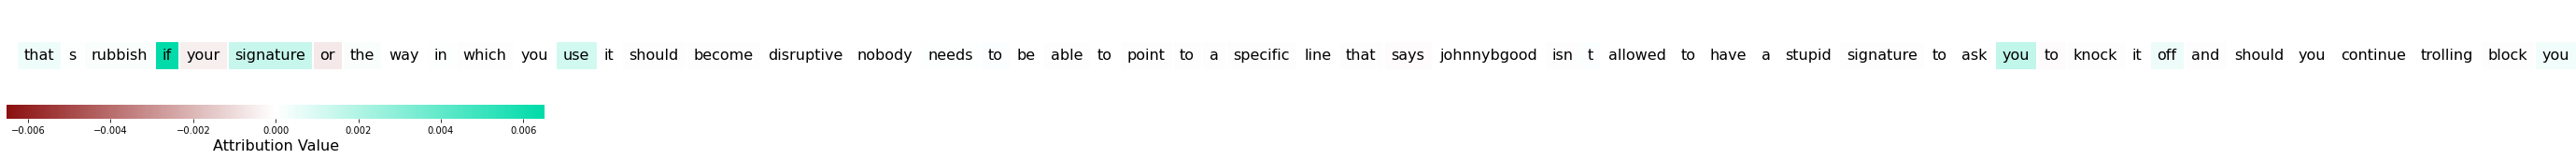

In [ ]:
baseline_embedding, batch_embedding, tokenized_text = get_embeddings(text[1250])
attributions = explainer.attributions(inputs=batch_embedding,
                                      baseline=baseline_embedding,
                                      batch_size=1,
                                      num_samples=128,
                                      use_expectation=True,
                                      output_indices=1)

attributions = np.mean(attributions, axis = 2)

decoded_sentence = tokenizer.batch_decode(tokenized_text['input_ids'])
sentence = decoded_sentence[0].replace("[PAD]", "").split()
sentence = sentence[1:-1]

text_plot(sentence,
          attributions[0][:len(sentence)],
          include_legend=True, multialignment = "left")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


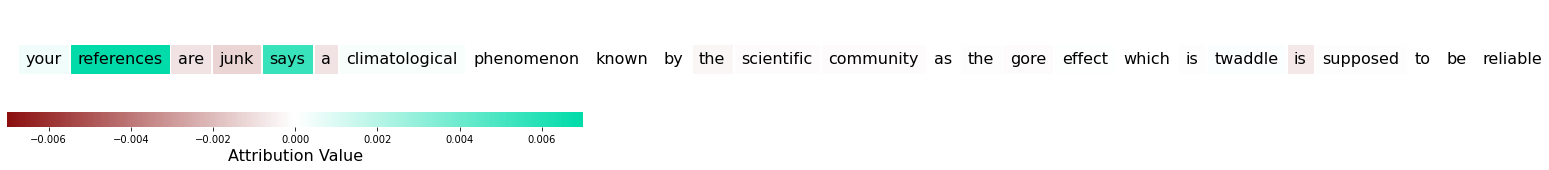

In [ ]:
baseline_embedding, batch_embedding, tokenized_text = get_embeddings(text[1174])
attributions = explainer.attributions(inputs=batch_embedding,
                                      baseline=baseline_embedding,
                                      batch_size=1,
                                      num_samples=128,
                                      use_expectation=True,
                                      output_indices=1)

attributions = np.mean(attributions, axis = 2)

decoded_sentence = tokenizer.batch_decode(tokenized_text['input_ids'])
sentence = decoded_sentence[0].replace("[PAD]", "").split()
sentence = sentence[1:-1]

text_plot(sentence,
          attributions[0][:len(sentence)],
          include_legend=True)
# shap.bar_plot(attributions[0][:len(sentence)], feature_names = sentence)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


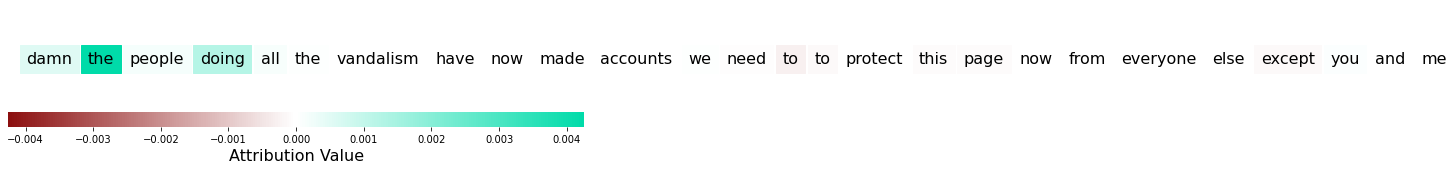

In [ ]:
baseline_embedding, batch_embedding, tokenized_text = get_embeddings(text[2863])
attributions = explainer.attributions(inputs=batch_embedding,
                                      baseline=baseline_embedding,
                                      batch_size=1,
                                      num_samples=128,
                                      use_expectation=True,
                                      output_indices=1)

attributions = np.mean(attributions, axis = 2)

decoded_sentence = tokenizer.batch_decode(tokenized_text['input_ids'])
sentence = decoded_sentence[0].replace("[PAD]", "").split()
sentence = sentence[1:-1]

text_plot(sentence,
          attributions[0][:len(sentence)],
          include_legend=True)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


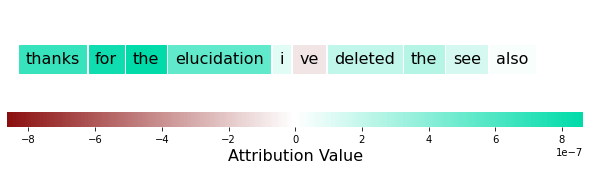

In [ ]:
baseline_embedding, batch_embedding, tokenized_text = get_embeddings(text[317])
attributions = explainer.attributions(inputs=batch_embedding,
                                      baseline=baseline_embedding,
                                      batch_size=1,
                                      num_samples=128,
                                      use_expectation=True,
                                      output_indices=1)

attributions = np.mean(attributions, axis = 2)

decoded_sentence = tokenizer.batch_decode(tokenized_text['input_ids'])
sentence = decoded_sentence[0].replace("[PAD]", "").split()
sentence = sentence[1:-1]

text_plot(sentence,
          attributions[0][:len(sentence)],
          include_legend=True)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3478: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


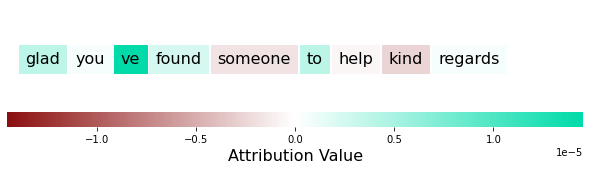

In [ ]:
baseline_embedding, batch_embedding, tokenized_text = get_embeddings(text[325])
attributions = explainer.attributions(inputs=batch_embedding,
                                      baseline=baseline_embedding,
                                      batch_size=1,
                                      num_samples=128,
                                      use_expectation=True,
                                      output_indices=1)

attributions = np.mean(attributions, axis = 2)

decoded_sentence = tokenizer.batch_decode(tokenized_text['input_ids'])
sentence = decoded_sentence[0].replace("[PAD]", "").split()
sentence = sentence[1:-1]

text_plot(sentence,
          attributions[0][:len(sentence)],
          include_legend=True)
